In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
sj_dataset = pd.read_csv(filepath_or_buffer='custom_datasets/dataset_iq.csv')
sj_testset = pd.read_csv(filepath_or_buffer='custom_datasets/testset_iq.csv')

In [4]:
sj_dataset['week_start_date'] =  pd.to_datetime(sj_dataset['week_start_date'])
sj_testset['week_start_date'] =  pd.to_datetime(sj_testset['week_start_date'])

In [5]:
sj_dataset = sj_dataset.set_index('week_start_date')
sj_testset = sj_testset.set_index('week_start_date')

In [6]:
sj_dataset.head()

,ndvi_ne,ndvi_nw,ndvi_se,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,
2000-07-01,0.192886,0.132257,0.340886,25.41,296.740000,295.184286,307.3,293.1,43.19,92.418571,26.400000,10.775000,32.5,20.7,3.0,0
2000-07-08,0.216833,0.276100,0.289457,60.61,296.634286,295.358571,306.6,291.1,46.00,93.581429,26.900000,11.566667,34.0,20.8,55.6,0
2000-07-15,0.176757,0.173129,0.204114,55.52,296.415714,295.622857,304.5,292.6,64.77,95.848571,26.800000,11.466667,33.0,20.7,38.1,0
2000-07-22,0.227729,0.145429,0.254200,5.60,295.357143,292.797143,303.6,288.6,23.96,87.234286,25.766667,10.533333,31.5,14.7,30.0,0
2000-07-29,0.328643,0.322129,0.254371,62.76,296.432857,293.957143,307.0,291.5,31.80,88.161429,26.600000,11.480000,33.3,19.1,4.0,0


In [7]:
sj_train = sj_dataset.copy()
sj_train.drop(['total_cases'],axis=1,inplace=True)

In [8]:
sj_train.shape

(516, 15)

In [9]:
sj_target = pd.DataFrame()
sj_target['total_cases'] = sj_dataset['total_cases']

In [10]:
sj_target.head()

,total_cases
week_start_date,
2000-07-01,0
2000-07-08,0
2000-07-15,0
2000-07-22,0
2000-07-29,0


In [11]:
x_data = sj_train.values[:]

In [12]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (516, 15)


In [13]:
y_data = sj_target.values

In [14]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (516, 1)


In [15]:
num_data = len(x_data)
num_data

516

In [16]:
train_split = 0.85

In [17]:
num_train = int(train_split * num_data)
num_train

438

In [18]:
num_test = num_data - num_train
num_test

78

In [19]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

516

In [20]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

516

In [21]:
num_x_signals = x_data.shape[1]
num_x_signals

15

In [22]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [23]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -0.019300000000000005
Max: 543.3


In [24]:
x_scaler = MinMaxScaler()

In [25]:
x_train_scaled = x_scaler.fit_transform(x_train)

In [26]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [27]:
x_test_scaled = x_scaler.transform(x_test)

In [28]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

/home/chamath/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(438, 15)
(438, 1)


In [30]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [31]:
batch_size = 10

In [32]:
sequence_length =  7 * 4
sequence_length

28

In [33]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [34]:
x_batch, y_batch = next(generator)

In [35]:
print(x_batch.shape)
print(y_batch.shape)

(10, 28, 15)
(10, 28, 1)


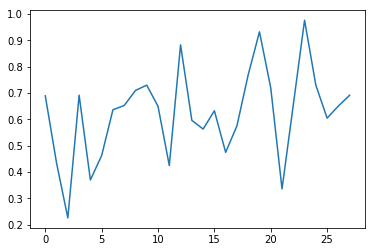

In [36]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

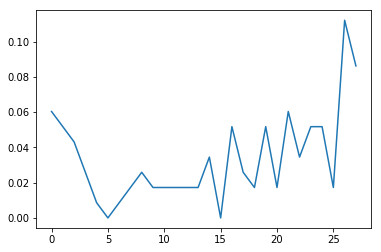

In [37]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [38]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [39]:
model = Sequential()

In [40]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

Instructions for updating:
Colocations handled automatically by placer.


In [41]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [42]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [43]:
warmup_steps = 5

In [44]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [45]:
optimizer = RMSprop(lr=1e-3)

In [46]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

Instructions for updating:
Use tf.cast instead.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         811008    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 811,521
Trainable params: 811,521
Non-trainable params: 0
_________________________________________________________________


In [48]:
path_checkpoint = 'iq_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [49]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

In [50]:
callback_tensorboard = TensorBoard(log_dir='./iq_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [51]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=3,
                                       verbose=1)

In [52]:
callbacks = [
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [53]:
%%time
model.fit_generator(generator=generator,
                    epochs=100,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 0s 63ms/sample - loss: 0.0031

Epoch 00001: val_loss improved from inf to 0.00305, saving model to iq_checkpoint.keras
100/100 [==============================] - 4s 41ms/step - loss: 0.0112 - val_loss: 0.0031
Epoch 2/100
1/1 [==============================] - 0s 16ms/sample - loss: 0.0028

Epoch 00002: val_loss improved from 0.00305 to 0.00282, saving model to iq_checkpoint.keras
100/100 [==============================] - 3s 30ms/step - loss: 0.0088 - val_loss: 0.0028
Epoch 3/100
1/1 [==============================] - 0s 15ms/sample - loss: 0.0034

Epoch 00003: val_loss did not improve from 0.00282
100/100 [==============================] - 3s 28ms/step - loss: 0.0080 - val_loss: 0.0034
Epoch 4/100
1/1 [==============================] - 0s 16ms/sample - loss: 0.0037

Epoch 00004: val_loss did not improve from 0.00282
100/100 [==============================] - 3s 28ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 5/100
1/1 [=============

In [54]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [55]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 19ms/sample - loss: 0.0026


In [56]:
print("loss (test-set):", result)

loss (test-set): 0.0026460415683686733


In [57]:
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

In [58]:
def plot_comparison(start_idx, length=5, train=False):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

    signal_pred = y_pred_rescaled[:]
    signal_true = y_true[:]

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
        
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
    # Plot labels etc.
    plt.ylabel('total_cases')
    plt.legend()
    plt.show()

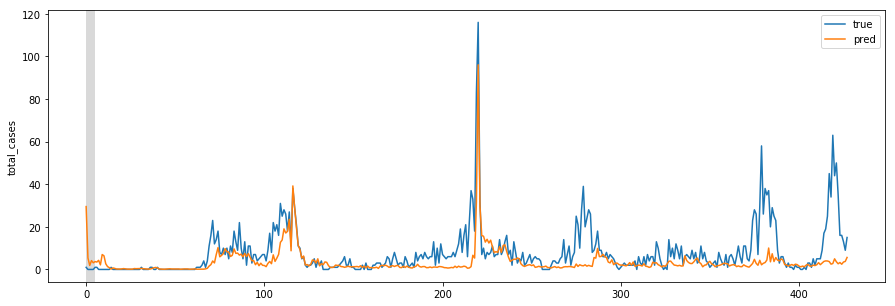

In [59]:
plot_comparison(start_idx=10, length=500, train=True)

In [60]:
test_sj = sj_testset.values[:]

In [61]:
test_sj.shape

(156, 15)

In [62]:
test_sj_scaled = x_scaler.transform(test_sj)

In [63]:
print("Min:", np.min(test_sj_scaled))
print("Max:", np.max(test_sj_scaled))

Min: -0.07954545454545325
Max: 1.0483941926968763


In [64]:
x = test_sj_scaled
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


In [65]:
y_pred_rescaled.shape

(156, 1)

In [66]:
y_pred_rescaled = y_pred_rescaled.astype(int)

In [67]:
sj_sub = pd.DataFrame({'total_cases':y_pred_rescaled[:,0]})

In [68]:
sj_sub.head()

,total_cases
0,28
1,7
2,6
3,5
4,2


In [69]:
sj_sub.to_csv('Submission_iq.csv', index = False)